In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-12-12 13:38:59.538874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
import numpy as np
import pandas as pd

In [21]:
image_size = 256
batch_size = 32
channels=3
epochs = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("folder/Training", shuffle = True, image_size=(image_size, image_size), batch_size = batch_size)


Found 3251 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
len(dataset)

102

In [6]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

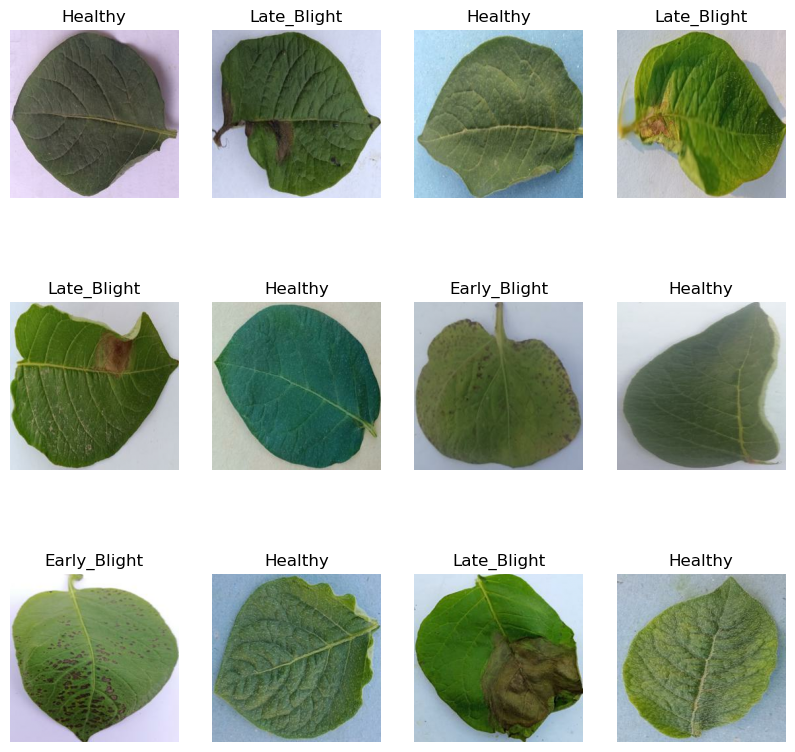

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8") / 255)
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#Defining function for train validation test split
def get_dataset_partitions_tf(ds, train_split=0.8, validation_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 100000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(validation_size)
    test_ds = ds.skip(train_size).skip(validation_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [16]:
input_shape = (batch_size,image_size,image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),    
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [22]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/10
81/81 [==============================] - 99s 1s/step - loss: 0.1729 - accuracy: 0.9426 - val_loss: 0.1199 - val_accuracy: 0.9625
Epoch 2/10
81/81 [==============================] - 104s 1s/step - loss: 0.1380 - accuracy: 0.9558 - val_loss: 0.0995 - val_accuracy: 0.9656
Epoch 3/10
81/81 [==============================] - 109s 1s/step - loss: 0.1622 - accuracy: 0.9449 - val_loss: 0.2154 - val_accuracy: 0.9250
Epoch 4/10
81/81 [==============================] - 96s 1s/step - loss: 0.1226 - accuracy: 0.9593 - val_loss: 0.2444 - val_accuracy: 0.9187
Epoch 5/10
81/81 [==============================] - 104s 1s/step - loss: 0.1589 - accuracy: 0.9449 - val_loss: 0.1129 - val_accuracy: 0.9625
Epoch 6/10
81/81 [==============================] - 111s 1s/step - loss: 0.1239 - accuracy: 0.9597 - val_loss: 0.1033 - val_accuracy: 0.9719
Epoch 7/10
81/81 [==============================] - 103s 1s/step - loss: 0.0773 - accuracy: 0.9771 - val_loss: 0.0813 - val_accuracy: 0.9719
Epoch 8/10
81/8

In [24]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 6s 342ms/step - loss: 0.0905 - accuracy: 0.9830


In [25]:
scores

[0.0905376747250557, 0.9829545617103577]

print(history)
print(history.params)
print(history.history.keys())
print(len(history.history["accuracy"]))

In [27]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

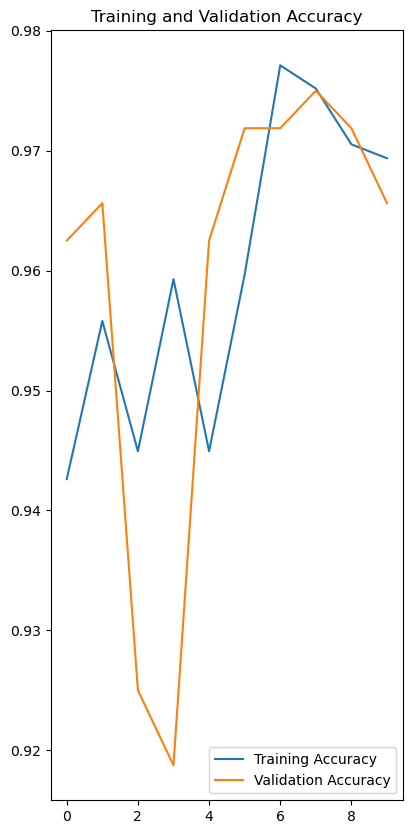

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label="Training Accuracy")
plt.plot(range(epochs), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


first image to predict
actual label:  Late_Blight
1/1 [==============================] - 0s 442ms/step
predicted label:  Late_Blight


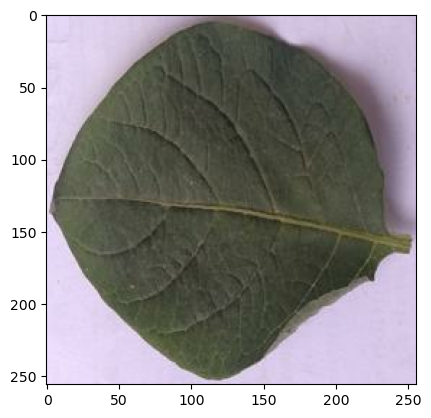

In [31]:
for images_batch , labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_predictions = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_predictions[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class , confidence

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence: {confidence}")

            
        plt.axis("off")

In [38]:
import os
model_version = max([int(i) for i in os.listdir("./models")]+[0]) + 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets
